# Classification of Native and Non-Native English Accents

In [1]:
import os
import IPython.display as ipd
import librosa
# import librosa.display
import matplotlib.pyplot as plt
import torch
import torchaudio
import torchaudio.transforms as TaudioT
import numpy as np
import random
import pandas as pd

## Data Exploration

The different accents we have in our dataset

In [2]:
data_path = './accentdb_extended_combined/data/'
accents = [accent for accent in os.listdir(data_path) if accent[0] != '.']
print(accents)
print('count: ', len(accents))

['indian', 'malayalam', 'australian', 'odiya', 'welsh', 'telugu', 'bangla', 'british', 'american']
count:  9


The number of audio samples we have for each accents

In [3]:
for accent in accents:
    files = [file for file in os.listdir(data_path + accent + '/') if file[0] != '.']
    print((accent, len(files)))

('indian', 1484)
('malayalam', 2393)
('australian', 1484)
('odiya', 747)
('welsh', 742)
('telugu', 1515)
('bangla', 1528)
('british', 1484)
('american', 5936)


Let's take a sample wave file and listen to what the recording sounds like.

In [4]:
wave_file = "./accentdb_extended_combined/data/indian/indian_s01_008.wav"
# Audio is part of IPython's disply module providing audio controls
ipd.Audio(filename=wave_file)

Let's see a pressure vs time graph of the wave file

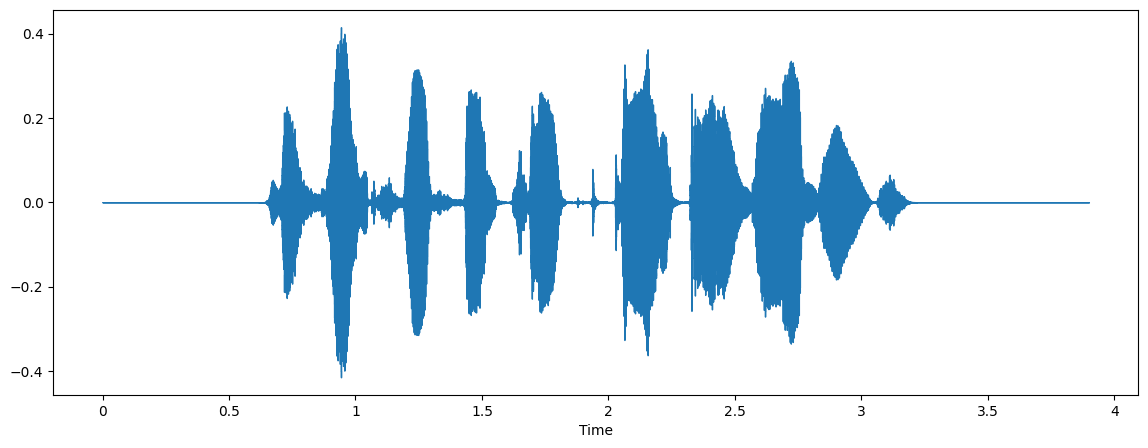

In [5]:
# librosa is a python package for music and audio analysis
# load converts a wave file to audio time series numpy array
# return:
# x -> numpy ndarray; audio time series multi channel supported
# sr -> scalar value; sample rate
x, sr = librosa.load(wave_file)
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)
plt.show()

Mel-frequency cepstral coefficients (MFCC) is known in the audio signal analisys field to be the best representation for human speech audio signals.  Let's convert this wave file into an MFCC frame, and see what it looks like.

(30, 168)


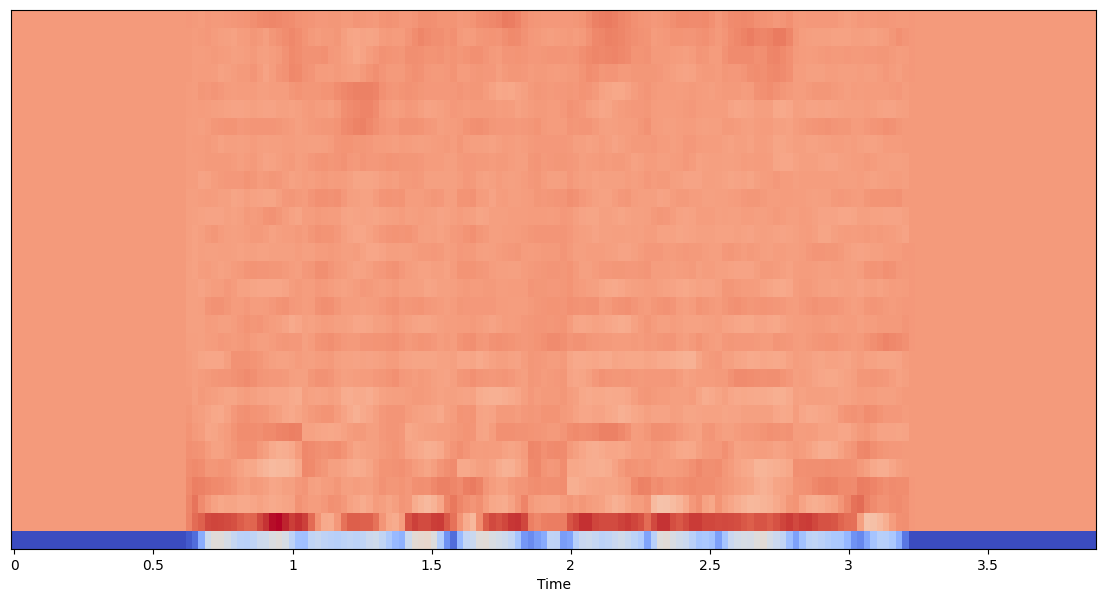

In [6]:
# librosa's feature extraction module mfcc converter
# returns a numpy array of mfcc sequence
mfccs = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=30)
print(mfccs.shape)

plt.figure(figsize=(14, 7))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.show()

Exploring meta data

indian
AudioMetaData(sample_rate=22050, num_frames=81585, num_channels=1, bits_per_sample=16, encoding=PCM_S)


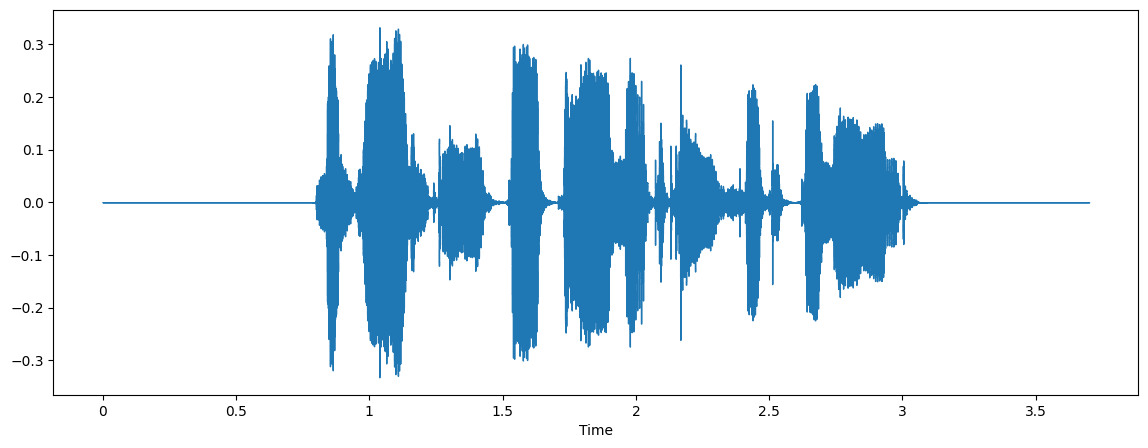

malayalam
AudioMetaData(sample_rate=48000, num_frames=249600, num_channels=2, bits_per_sample=16, encoding=PCM_S)


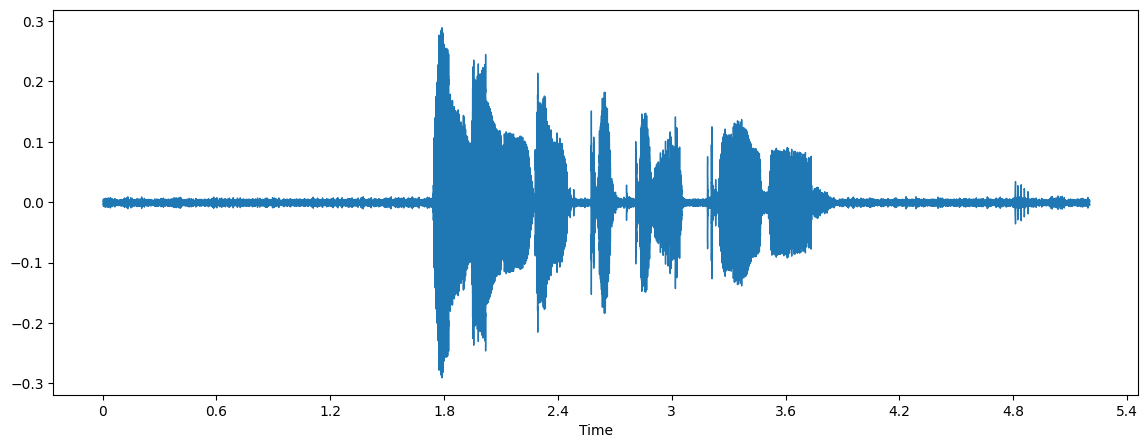

australian
AudioMetaData(sample_rate=22050, num_frames=77175, num_channels=1, bits_per_sample=16, encoding=PCM_S)


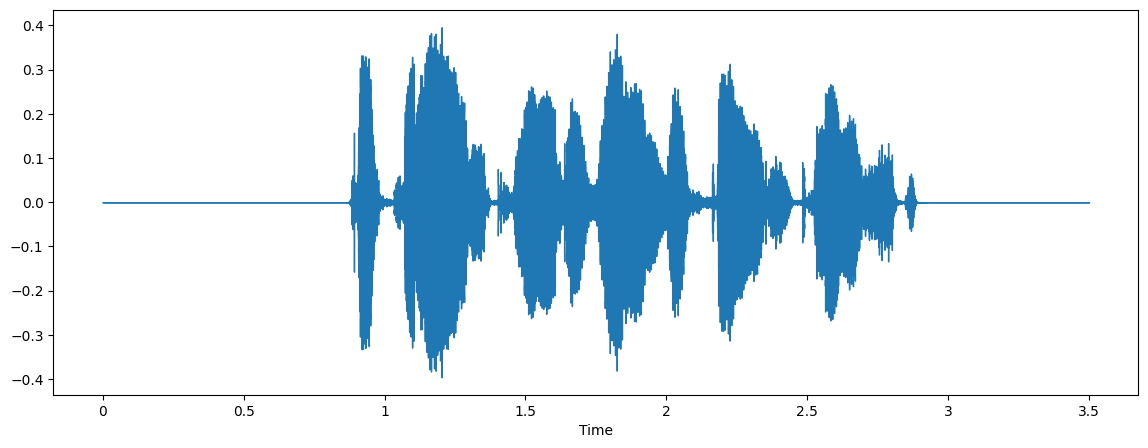

odiya
AudioMetaData(sample_rate=48000, num_frames=220800, num_channels=2, bits_per_sample=16, encoding=PCM_S)


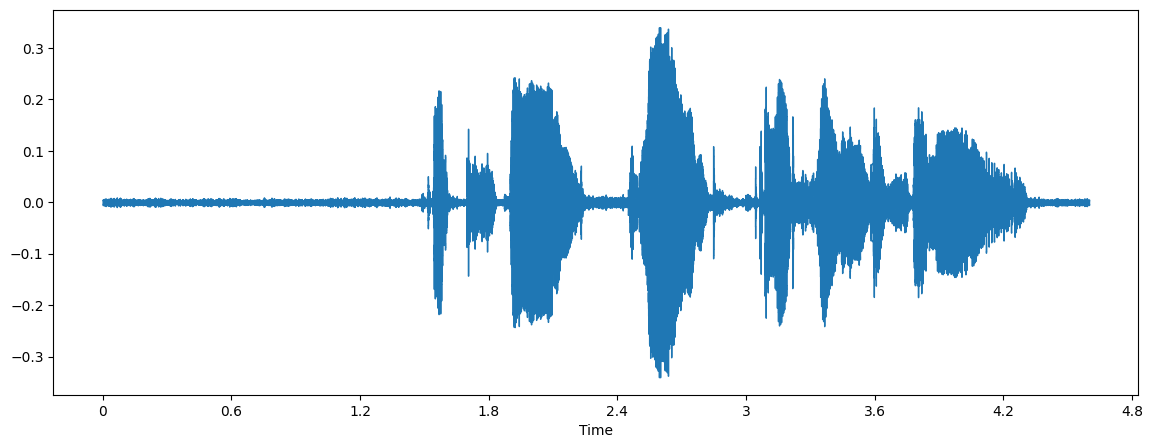

welsh
AudioMetaData(sample_rate=22050, num_frames=74970, num_channels=1, bits_per_sample=16, encoding=PCM_S)


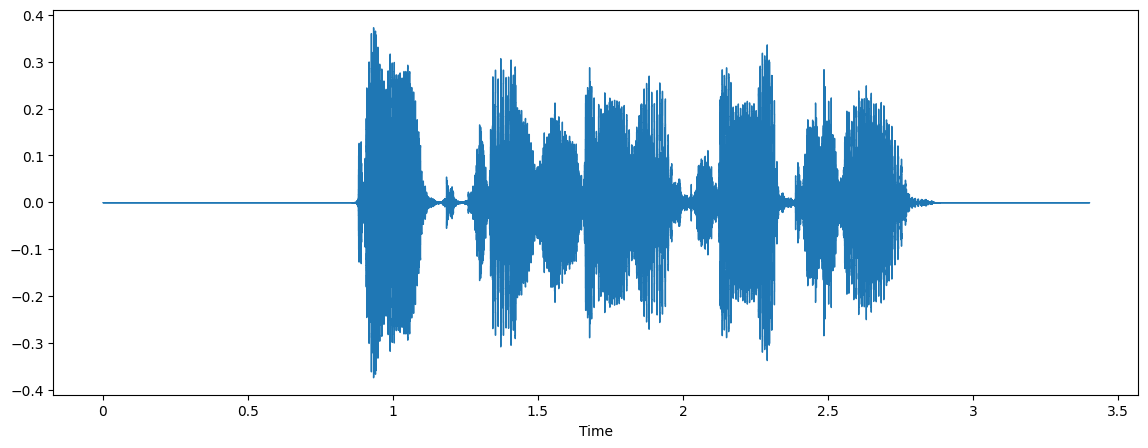

telugu
AudioMetaData(sample_rate=48000, num_frames=249600, num_channels=2, bits_per_sample=16, encoding=PCM_S)


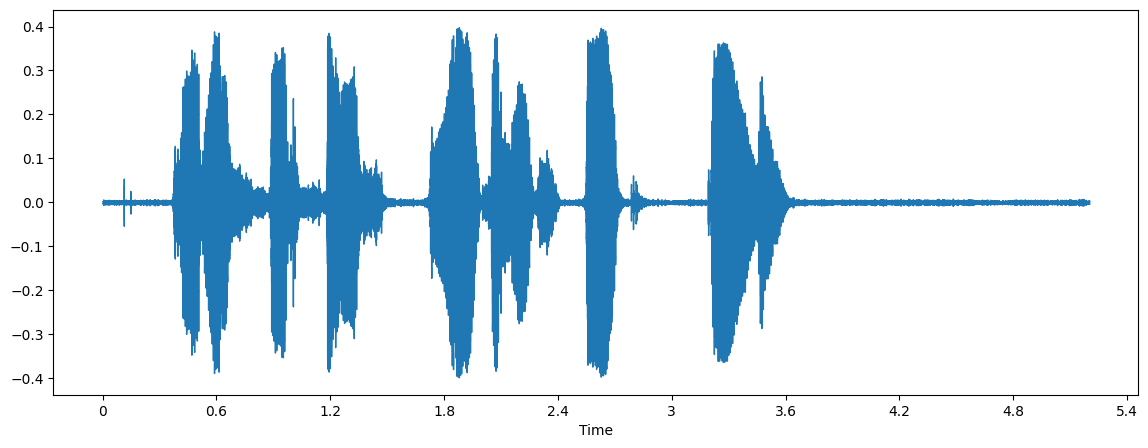

bangla
AudioMetaData(sample_rate=48000, num_frames=249600, num_channels=2, bits_per_sample=16, encoding=PCM_S)


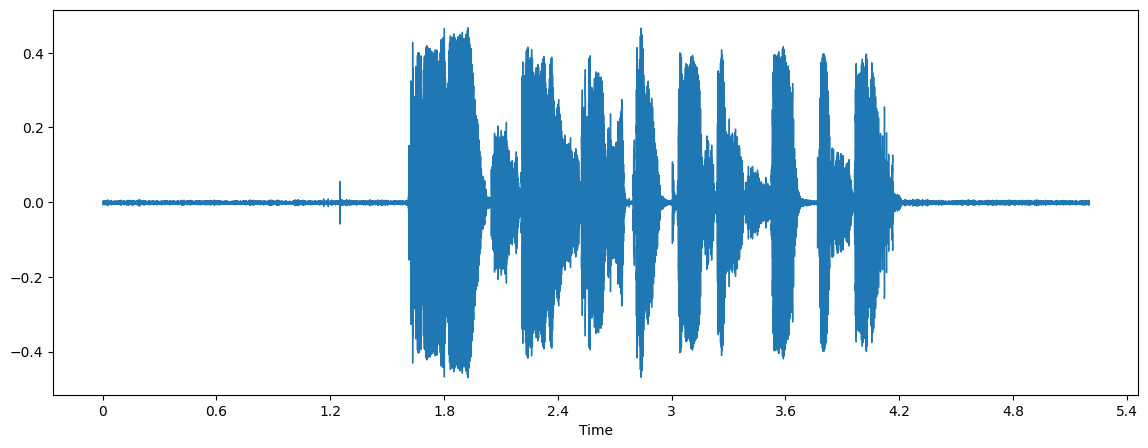

british
AudioMetaData(sample_rate=22050, num_frames=81585, num_channels=1, bits_per_sample=16, encoding=PCM_S)


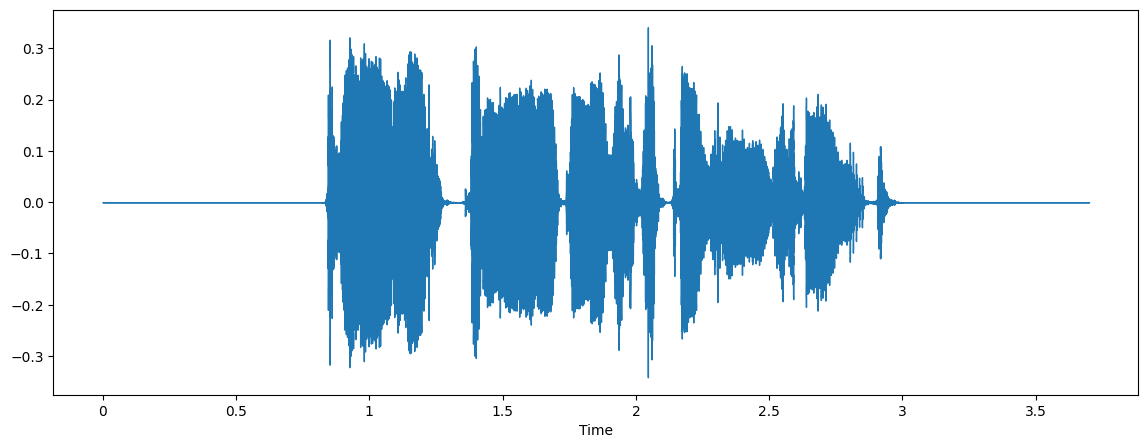

american
AudioMetaData(sample_rate=22050, num_frames=68355, num_channels=1, bits_per_sample=16, encoding=PCM_S)


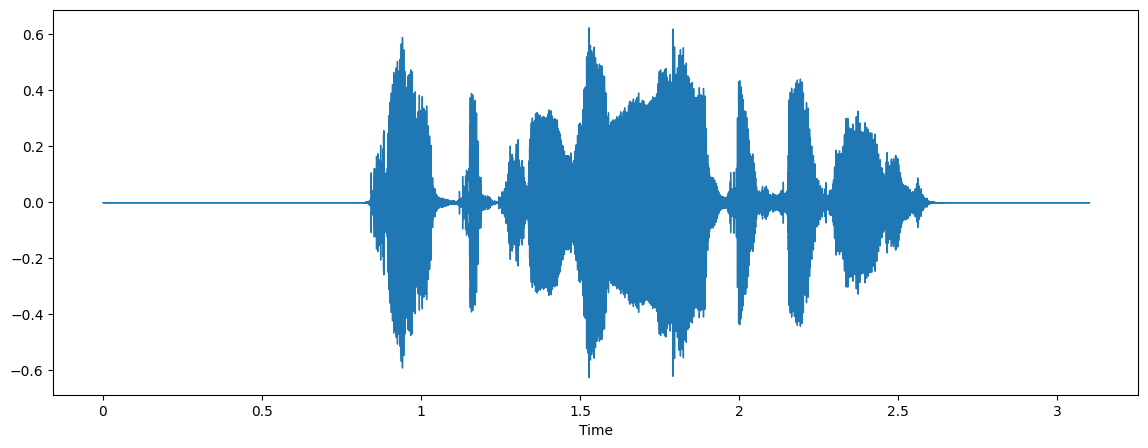

In [7]:
for accent in accents:
    path = data_path + accent + '/'
    print(accent)
    directory = [file for file in os.listdir(path) if file[0] != '.']
    for file in directory:
        file_path = path + file
        print(torchaudio.info(file_path))
        x, sr = librosa.load(file_path)
        plt.figure(figsize=(14, 5))
        librosa.display.waveshow(x, sr=sr)
        plt.show()
        break

We see difference in sample rate (22050 vs 48000) and number of channels (mono vs stereo) which translates into difference in dimensions of resulting MFCC representation which is an issue for our modeling process that we need to address.

In [8]:
# helper functions
def mono_to_stereo(signal):
    x, sr = signal
    if x.shape[0] == 2:
        return signal
    stereo = torch.cat([x, x])
    return stereo, sr

def resample(signal, new_sr=22050):
    x, sr = signal
    if sr == new_sr:
        return signal
    channel_1 = TaudioT.Resample(sr, new_sr)(x[:1, :])
    channel_2 = TaudioT.Resample(sr, new_sr)(x[1:, :])
    new_x = torch.cat([channel_1, channel_2])
    return new_x, new_sr

def limit_length(sig, ms=3000):
    x, sr = sig
    rows, audio_len = x.shape
    max_len = sr // 1000 * ms

    if audio_len > max_len:
        x = x[:, :max_len]
    elif audio_len < max_len:
        diff = max_len - audio_len
        append_start_len = random.randint(0, diff)
        append_stop_len = diff - append_start_len
        append_start = torch.zeros((rows, append_start_len))
        append_stop = torch.zeros((rows, append_stop_len))

        x = torch.cat((append_start, x, append_stop), 1)
    return x, sr

def mfcc(signal, n_mels=20):
    x, sr = signal
    melkwargs = {
        "n_fft": 512, "n_mels": n_mels, "hop_length": None, "mel_scale": "htk"
    }
    mfcc_transformer = TaudioT.MFCC(
        sample_rate = sr,
        n_mfcc = n_mels,
        melkwargs=melkwargs
    )
    mfcc_frames = mfcc_transformer(x)
    spec = TaudioT.AmplitudeToDB(top_db=80)(mfcc_frames)
    return spec


Let's convert one audio sample to see what we are dealing with

In [9]:
signal = torchaudio.load(wave_file)
signal = mono_to_stereo(signal)
signal = resample(signal)
signal = limit_length(signal)
mfcc_frame = mfcc(signal)

print(mfcc_frame.shape)

mfcc_frame

torch.Size([2, 20, 258])


tensor([[[-60.6520, -60.6520, -60.6520,  ..., -60.6520, -60.6520, -60.6520],
         [-51.1751, -51.1751, -51.1751,  ...,  17.6589,  17.0803,  15.8415],
         [-60.6520, -60.6520, -60.6520,  ...,   9.8607,  12.2282,  15.3684],
         ...,
         [-42.0936, -42.0936, -42.0936,  ...,  -3.7579,   5.5471,   3.9661],
         [-60.6520, -60.6520, -60.6520,  ...,  -2.3994, -60.6520,   2.3849],
         [-39.7187, -39.7187, -39.7187,  ..., -60.6520, -22.3304, -60.6520]],

        [[-60.6520, -60.6520, -60.6520,  ..., -60.6520, -60.6520, -60.6520],
         [-51.1751, -51.1751, -51.1751,  ...,  17.6589,  17.0803,  15.8415],
         [-60.6520, -60.6520, -60.6520,  ...,   9.8607,  12.2282,  15.3684],
         ...,
         [-42.0936, -42.0936, -42.0936,  ...,  -3.7579,   5.5471,   3.9661],
         [-60.6520, -60.6520, -60.6520,  ...,  -2.3994, -60.6520,   2.3849],
         [-39.7187, -39.7187, -39.7187,  ..., -60.6520, -22.3304, -60.6520]]])

In [11]:
def convert(wave, n_mels=20):
    signal = torchaudio.load(wave)
    signal = mono_to_stereo(signal)
    signal = resample(signal)
    signal = limit_length(signal)
    spec = mfcc(signal, n_mels=n_mels)
    return spec

Let's convert the rest of the audio samples.  Since "welsh" has the lowest number of samples at 742, to keep balance in our dataset, we will convert 742 samples from each accent, and take the full 5936 from "american" for a perfectly balanced dataset for a binary classification predicting "american" vs "non-american" accents (8 x 742 = 5936)

In [12]:
X_full = []
y_full = []

for accent in accents:
    count = 742 if accent != 'american' else 5936
    target_label = 0 if accent != 'american' else 1
    for file in os.listdir(data_path + accent + '/'):
        if file[0] != '.':
            wave_file_path = data_path + accent + '/' + file
            X_full.append(convert(wave_file_path))
            y_full.append(target_label)
            count -= 1
        if count == 0: break


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


In [13]:
X_full = np.stack(X_full)
y_full = np.array(y_full)

In [14]:
X_full.shape

(11872, 2, 20, 258)

In [15]:
y_full.shape

(11872,)

Save 4D numpy array and target vector to disk

In [16]:
np.save('american-v-all-4D.npy', X_full)

In [17]:
np.save('american-v-all-target.npy', y_full)

Scale 4D data to [0, 1]

In [18]:
X_min = X_full.min(axis=(0, 1), keepdims=True)
X_max = X_full.max(axis=(0, 1), keepdims=True)

X_full_norm = (X_full - X_min)/(X_max - X_min)

In [19]:
print('x_full_norm:\n ', X_full_norm[0][0])

x_full_norm:
  [[0.03326382 0.03323746 0.0332142  ... 0.03109878 0.03110528 0.03107949]
 [0.21245302 0.21058188 0.21028045 ... 0.98643553 0.986415   0.9818898 ]
 [0.0311528  0.03129443 0.03131645 ... 0.9633707  0.9779532  0.95568055]
 ...
 [0.28428563 0.290874   0.2897371  ... 0.85257155 0.8462503  0.02101049]
 [0.03492031 0.03572507 0.03596684 ... 0.92736053 0.8734211  0.9054428 ]
 [0.32462537 0.32882282 0.3253497  ... 0.02078271 0.911911   0.9519666 ]]


Let's convert another set with a higher n_mel value to have a more detailed representation of each wave file and a higher dimensional data to work with for more powerful machine learning algorithms.  In addition we will attempt multiclass classification models predicting each accents available in our dataset.

In [20]:
X_hd_full = []
y_hd_full = []

for accent in accents:
    count = 742
    for file in os.listdir(data_path + accent + '/'):
        if file[0] != '.':
            wave_file_path = data_path + accent + '/' + file
            X_hd_full.append(convert(wave_file_path, n_mels=64))
            y_hd_full.append(accents.index(accent))
            count -= 1
        if count == 0: break


In [21]:
X_hd_full = np.stack(X_hd_full)
y_hd_full = np.stack(y_hd_full)

In [22]:
print('X_hd_full: ', X_hd_full.shape)
print('y_hd_full: ', y_hd_full.shape)

X_hd_full:  (6678, 2, 64, 258)
y_hd_full:  (6678,)


Let's make sure our target values reflect each class within our y vector

In [23]:
index = 0
for i in range(9):
    index += i + 741 if i == 0 else 742
    print(f'For {accents[i]} the target value is {y_hd_full[index]}')

For indian the target value is 0
For malayalam the target value is 1
For australian the target value is 2
For odiya the target value is 3
For welsh the target value is 4
For telugu the target value is 5
For bangla the target value is 6
For british the target value is 7
For american the target value is 8


Save 4D high dimension multiclass dataset onto disk

In [24]:
np.save('multiclass-4D-hd.npy', X_hd_full)

In [25]:
np.save('multiclass-4D-hd-target.npy', y_hd_full)

Scale 4D high dimensional multiclass dataset to [0, 1]

In [26]:
X_hd_min = X_hd_full.min(axis=(0, 1), keepdims=True)
X_hd_max = X_hd_full.max(axis=(0, 1), keepdims=True)

X_hd_full_norm = (X_hd_full - X_hd_min)/(X_hd_max - X_hd_min)

In [27]:
print(X_hd_full_norm)

[[[[0.47831094 0.47831094 0.47831094 ... 0.02559392 0.02404624
    0.02418319]
   [0.01848506 0.01844537 0.01842941 ... 0.9847526  0.9857897
    0.9787905 ]
   [0.01992386 0.01989776 0.01992458 ... 0.96644574 0.98090655
    0.96010405]
   ...
   [0.02459069 0.0248081  0.02355036 ... 0.81786054 0.02437684
    0.9058159 ]
   [0.32852045 0.33474532 0.3316428  ... 0.8438007  0.93301886
    0.0215213 ]
   [0.31081307 0.31483445 0.31676856 ... 0.9386184  0.9236432
    0.02315252]]

  [[0.47831094 0.47831094 0.47831094 ... 0.02559392 0.02404624
    0.02418319]
   [0.01848506 0.01844537 0.01842941 ... 0.9847526  0.9857897
    0.9787905 ]
   [0.01992386 0.01989776 0.01992458 ... 0.96644574 0.98090655
    0.96010405]
   ...
   [0.02459069 0.0248081  0.02355036 ... 0.81786054 0.02437684
    0.9058159 ]
   [0.32852045 0.33474532 0.3316428  ... 0.8438007  0.93301886
    0.0215213 ]
   [0.31081307 0.31483445 0.31676856 ... 0.9386184  0.9236432
    0.02315252]]]


 [[[0.50025547 0.50025547 0.50025547

Restructuring our dataset from 4d to 2d

In [28]:
data = []
for audio in X_full:
    data.append(audio[0].flatten())

df = pd.DataFrame(data)
data = np.stack(data)

In [29]:
data.shape

(11872, 5160)

Save 2D array as csv

In [30]:
np.save('american-v-all-2D.npy', data)

### Train Test Split

In [31]:
from sklearn.model_selection import train_test_split

Splitting our 2D data for non neural net model fitting

In [32]:
X2d_train, X2d_test, y2d_train, y2d_test = train_test_split(data, y_full, test_size=0.15, random_state=42)

Splitting our 4D data for neural net model fitting

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_full_norm, y_full, test_size=0.15, random_state=42)

In [34]:
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (10091, 2, 20, 258)
y_train (10091,)
X_test (1781, 2, 20, 258)
y_test (1781,)


Splitting our 4D high dimensional data for more powerful neural networks

In [35]:
X_hd_train, X_hd_test, y_hd_train, y_hd_test = train_test_split(X_hd_full_norm, y_hd_full, test_size=0.15, random_state=42)

In [36]:
print('X_hd_train', X_hd_train.shape)
print('y_hd_train', y_hd_train.shape)
print('X_hd_test', X_hd_test.shape)
print('y_hd_test', y_hd_test.shape)

X_hd_train (5676, 2, 64, 258)
y_hd_train (5676,)
X_hd_test (1002, 2, 64, 258)
y_hd_test (1002,)


### Dimensionality Reduction of 2D data

#### PCA

In [37]:
from sklearn.decomposition import PCA

Peform principal component analysis while retaining 95% variance over our data

In [38]:
pca = PCA(n_components=0.95)

#### Random Forest as Feature Selection

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

In [40]:
rf_feature_select = SelectFromModel(RandomForestClassifier(n_estimators=100, max_leaf_nodes=9, n_jobs=-1))

### Combining Both Techniques

In [41]:
from sklearn.pipeline import Pipeline

In [42]:
full_pipeline = Pipeline(
    [('pca', pca), 
     ('rf', rf_feature_select)]
)

X2d_reduced = full_pipeline.fit_transform(X2d_train, y2d_train)

In [43]:
X2d_reduced.shape

(10091, 379)

Performing random forest as feature selection after having completed principal component analysis brought down the dimension of our data from 5160 to 379.  We will keep this setting as we explore the different models available to us.

## Exploring Different Models and Applying Performance Evaluation Metrics

### Logistic Regression

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [45]:
lr_model = Pipeline([
    ('pca', pca),
    ('rf', rf_feature_select),
    ('lr', LogisticRegression())
])

lr_model.fit(X2d_train, y2d_train)

/Users/nicholascaro/opt/anaconda3/envs/hello-tf/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('pca', PCA(n_components=0.95)),
                ('rf',
                 SelectFromModel(estimator=RandomForestClassifier(max_leaf_nodes=9,
                                                                  n_jobs=-1))),
                ('lr', LogisticRegression())])

In [50]:
lr_predict = lr_model.predict(X2d_test)

Classifcation Report, Confusion Matrix, ROC AUC Curve, and Precision - Recall Curve for Linear Regression Model

In [51]:
# classifcation report
lr_cr = metrics.classification_report(y2d_test, lr_predict)

# confusion matrix
lr_cm = metrics.confusion_matrix(y2d_test, lr_predict)
lr_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=lr_cm, display_labels= lr_model.classes_)

# roc auc curve 
lr_fpr, lr_tpr, lr_thresholds = metrics.roc_curve(y2d_test, lr_predict)
lr_roc_auc = metrics.auc(lr_fpr, lr_tpr)
lr_roc_auc_display = metrics.RocCurveDisplay(fpr=lr_fpr, tpr=lr_tpr, roc_auc=lr_roc_auc)

# precision recall curve
lr_precision, lr_recall, _ = metrics.precision_recall_curve(y2d_test, lr_predict)
lr_prec_reca_display = metrics.PrecisionRecallDisplay(precision=lr_precision, recall=lr_recall)


              precision    recall  f1-score   support

           0       0.96      0.91      0.94       892
           1       0.92      0.97      0.94       889

    accuracy                           0.94      1781
   macro avg       0.94      0.94      0.94      1781
weighted avg       0.94      0.94      0.94      1781



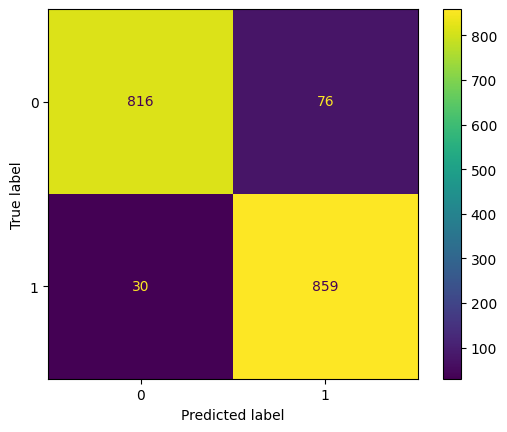

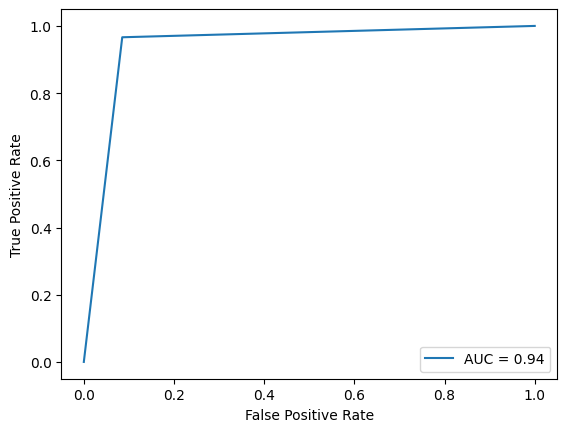

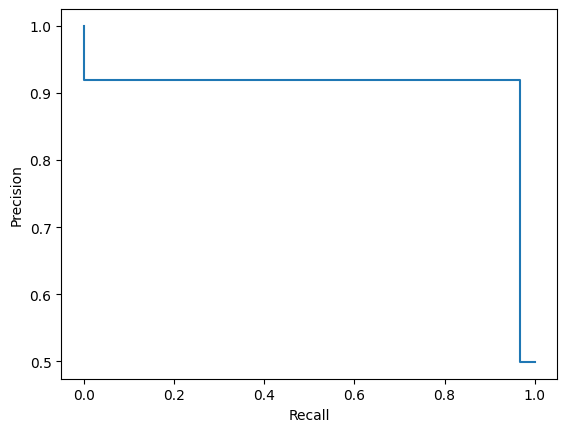

In [54]:
# classifcation report
print(lr_cr)

# confusion matrix display
lr_cm_display.plot()

# roc auc curve display
lr_roc_auc_display.plot()

# precision recall curve display
lr_prec_reca_display.plot()

### K-nearest Neighbors (KNN) Classifer

In [55]:
from sklearn.neighbors import KNeighborsClassifier

In [56]:
knn_model = Pipeline([
    ('pca', pca),
    ('rf', rf_feature_select),
    ('knn', KNeighborsClassifier(n_neighbors=7))
])

knn_model.fit(X2d_train, y2d_train)

Pipeline(steps=[('pca', PCA(n_components=0.95)),
                ('rf',
                 SelectFromModel(estimator=RandomForestClassifier(max_leaf_nodes=9,
                                                                  n_jobs=-1))),
                ('knn', KNeighborsClassifier(n_neighbors=7))])

In [57]:
knn_predict = knn_model.predict(X2d_test)

Classifcation Report, Confusion Matrix, ROC AUC Curve, and Precision - Recall Curve for KNN Model

In [58]:
# classifcation report
knn_cr = metrics.classification_report(y2d_test, knn_predict)

# confusion matrix
knn_cm = metrics.confusion_matrix(y2d_test, knn_predict)
knn_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=knn_cm, display_labels= knn_model.classes_)

# roc auc curve 
knn_fpr, knn_tpr, knn_thresholds = metrics.roc_curve(y2d_test, knn_predict)
knn_roc_auc = metrics.auc(knn_fpr, knn_tpr)
knn_roc_auc_display = metrics.RocCurveDisplay(fpr=knn_fpr, tpr=knn_tpr, roc_auc=knn_roc_auc)

# precision recall curve
knn_precision, knn_recall, _ = metrics.precision_recall_curve(y2d_test, knn_predict)
knn_prec_reca_display = metrics.PrecisionRecallDisplay(precision=knn_precision, recall=knn_recall)


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       892
           1       0.98      1.00      0.99       889

    accuracy                           0.99      1781
   macro avg       0.99      0.99      0.99      1781
weighted avg       0.99      0.99      0.99      1781



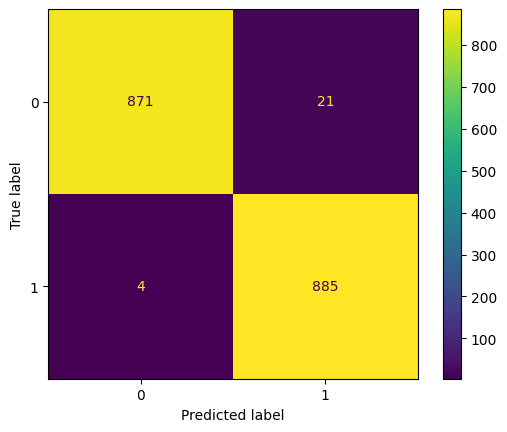

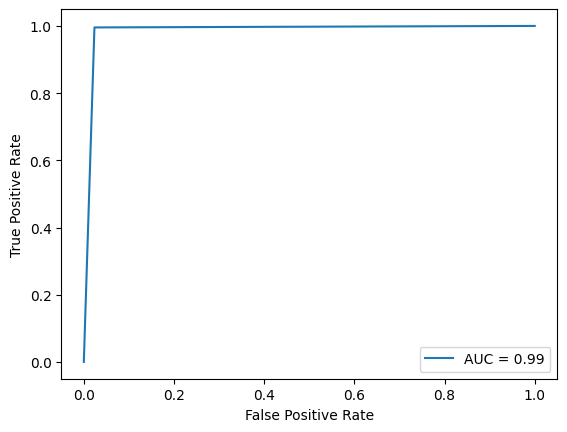

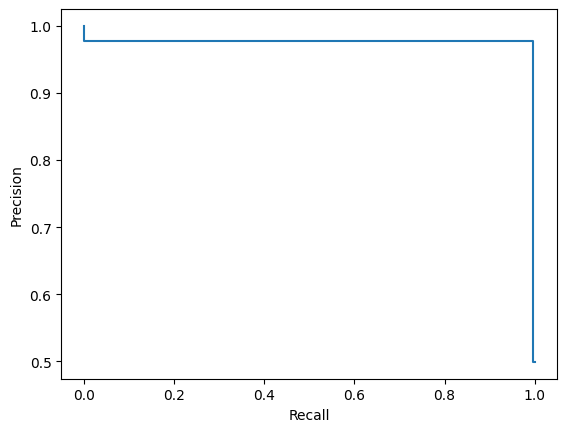

In [60]:
# classifcation report
print(knn_cr)

# confusion matrix display
knn_cm_display.plot()

# roc auc curve display
knn_roc_auc_display.plot()

# precision recall curve display
knn_prec_reca_display.plot()

### Support Vector Machines (SVM) Classifier

In [63]:
from sklearn.svm import SVC

In [64]:
svm_model = Pipeline([
    ('pca', pca),
    ('rf', rf_feature_select),
    ('svm', SVC())
])

svm_model.fit(X2d_train, y2d_train)

Pipeline(steps=[('pca', PCA(n_components=0.95)),
                ('rf',
                 SelectFromModel(estimator=RandomForestClassifier(max_leaf_nodes=9,
                                                                  n_jobs=-1))),
                ('svm', SVC())])

In [65]:
svm_predict = svm_model.predict(X2d_test)

Classifcation Report, Confusion Matrix, ROC AUC Curve, and Precision - Recall Curve for SVM Model

In [66]:
# classifcation report
svm_cr = metrics.classification_report(y2d_test, svm_predict)

# confusion matrix
svm_cm = metrics.confusion_matrix(y2d_test, svm_predict)
svm_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=svm_cm, display_labels= svm_model.classes_)

# roc auc curve 
svm_fpr, svm_tpr, svm_thresholds = metrics.roc_curve(y2d_test, svm_predict)
svm_roc_auc = metrics.auc(svm_fpr, svm_tpr)
svm_roc_auc_display = metrics.RocCurveDisplay(fpr=svm_fpr, tpr=svm_tpr, roc_auc=svm_roc_auc)

# precision recall curve
svm_precision, svm_recall, _ = metrics.precision_recall_curve(y2d_test, svm_predict)
svm_prec_reca_display = metrics.PrecisionRecallDisplay(precision=svm_precision, recall=svm_recall)


              precision    recall  f1-score   support

           0       0.99      0.98      0.99       892
           1       0.98      0.99      0.99       889

    accuracy                           0.99      1781
   macro avg       0.99      0.99      0.99      1781
weighted avg       0.99      0.99      0.99      1781



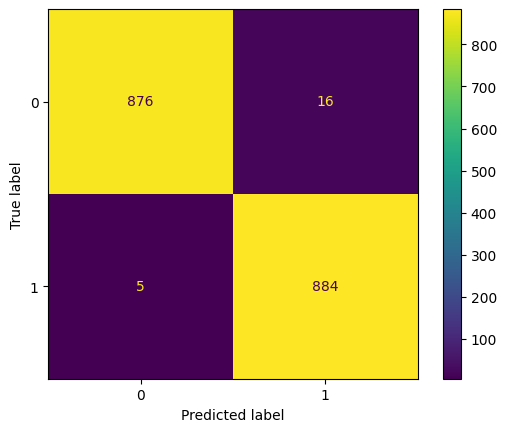

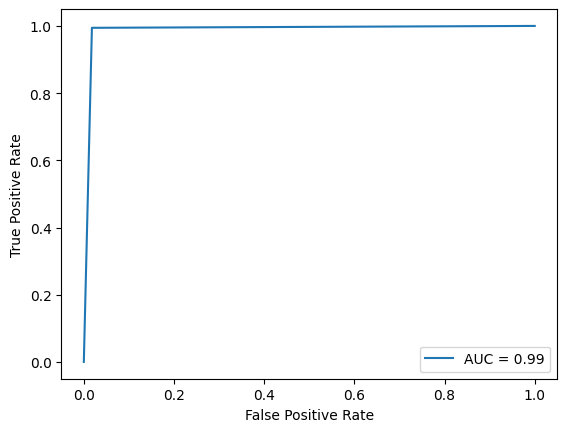

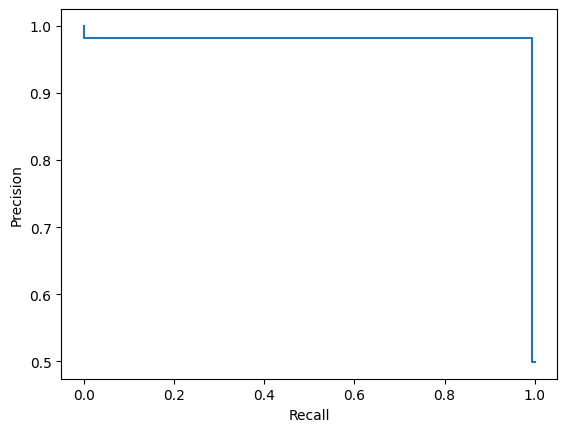

In [67]:
# classifcation report
print(svm_cr)

# confusion matrix display
svm_cm_display.plot()

# roc auc curve display
svm_roc_auc_display.plot()

# precision recall curve display
svm_prec_reca_display.plot()

### Decision Trees Classifier

In [68]:
from sklearn.tree import DecisionTreeClassifier

In [69]:
tree_model = Pipeline([
    ('pca', pca),
    ('rf', rf_feature_select),
    ('tree', DecisionTreeClassifier(max_leaf_nodes=50))
])

tree_model.fit(X2d_train, y2d_train)

Pipeline(steps=[('pca', PCA(n_components=0.95)),
                ('rf',
                 SelectFromModel(estimator=RandomForestClassifier(max_leaf_nodes=9,
                                                                  n_jobs=-1))),
                ('tree', DecisionTreeClassifier(max_leaf_nodes=50))])

In [70]:
tree_predict = tree_model.predict(X2d_test)

Classifcation Report, Confusion Matrix, ROC AUC Curve, and Precision - Recall Curve for Decision Tree Model

In [71]:
# classifcation report
tree_cr = metrics.classification_report(y2d_test, tree_predict)

# confusion matrix
tree_cm = metrics.confusion_matrix(y2d_test, tree_predict)
tree_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=tree_cm, display_labels= tree_model.classes_)

# roc auc curve 
tree_fpr, tree_tpr, tree_thresholds = metrics.roc_curve(y2d_test, tree_predict)
tree_roc_auc = metrics.auc(tree_fpr, tree_tpr)
tree_roc_auc_display = metrics.RocCurveDisplay(fpr=tree_fpr, tpr=tree_tpr, roc_auc=tree_roc_auc)

# precision recall curve
tree_precision, tree_recall, _ = metrics.precision_recall_curve(y2d_test, tree_predict)
tree_prec_reca_display = metrics.PrecisionRecallDisplay(precision=tree_precision, recall=tree_recall)


              precision    recall  f1-score   support

           0       0.95      0.96      0.95       892
           1       0.96      0.95      0.95       889

    accuracy                           0.95      1781
   macro avg       0.95      0.95      0.95      1781
weighted avg       0.95      0.95      0.95      1781



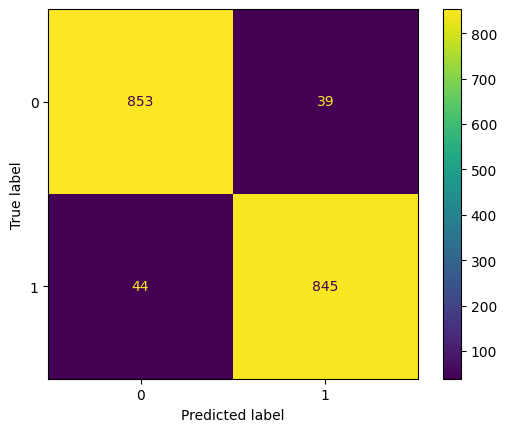

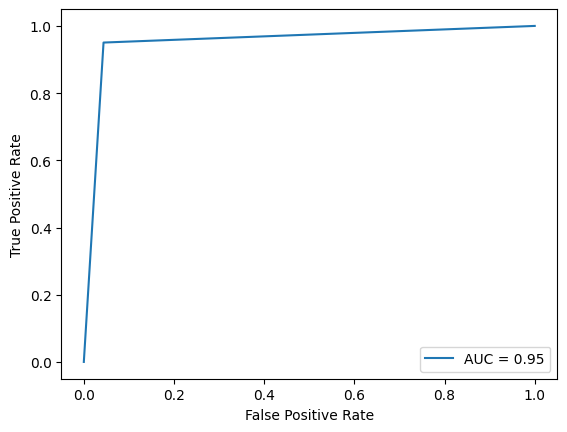

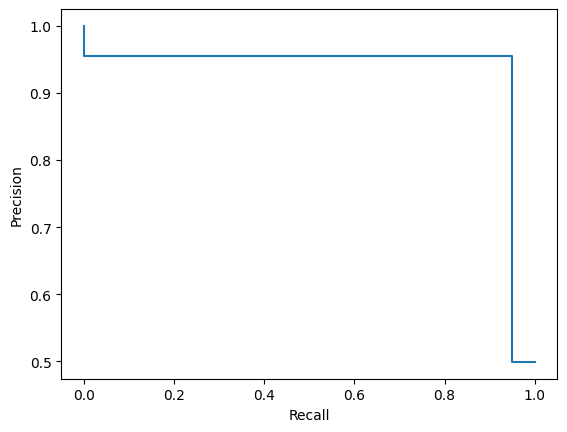

In [72]:
# classifcation report
print(tree_cr)

# confusion matrix display
tree_cm_display.plot()

# roc auc curve display
tree_roc_auc_display.plot()

# precision recall curve display
tree_prec_reca_display.plot()

### Random Forests Classifier

In [74]:
from sklearn.ensemble import RandomForestClassifier

In [75]:
forest_model = Pipeline([
    ('pca', pca),
    ('rf', rf_feature_select),
    ('tree', RandomForestClassifier(n_estimators=500, max_leaf_nodes=50, n_jobs=-1))
])

forest_model.fit(X2d_train, y2d_train)

Pipeline(steps=[('pca', PCA(n_components=0.95)),
                ('rf',
                 SelectFromModel(estimator=RandomForestClassifier(max_leaf_nodes=9,
                                                                  n_jobs=-1))),
                ('tree',
                 RandomForestClassifier(max_leaf_nodes=50, n_estimators=500,
                                        n_jobs=-1))])

In [76]:
forest_predict = forest_model.predict(X2d_test)

Classifcation Report, Confusion Matrix, ROC AUC Curve, and Precision - Recall Curve for Random Forest Model

In [77]:
# classifcation report
forest_cr = metrics.classification_report(y2d_test, forest_predict)

# confusion matrix
forest_cm = metrics.confusion_matrix(y2d_test, forest_predict)
forest_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=forest_cm, display_labels= forest_model.classes_)

# roc auc curve 
forest_fpr, forest_tpr, forest_thresholds = metrics.roc_curve(y2d_test, forest_predict)
forest_roc_auc = metrics.auc(forest_fpr, forest_tpr)
forest_roc_auc_display = metrics.RocCurveDisplay(fpr=forest_fpr, tpr=forest_tpr, roc_auc=forest_roc_auc)

# precision recall curve
forest_precision, forest_recall, _ = metrics.precision_recall_curve(y2d_test, forest_predict)
forest_prec_reca_display = metrics.PrecisionRecallDisplay(precision=forest_precision, recall=forest_recall)


              precision    recall  f1-score   support

           0       0.98      0.87      0.92       892
           1       0.88      0.98      0.93       889

    accuracy                           0.93      1781
   macro avg       0.93      0.93      0.93      1781
weighted avg       0.93      0.93      0.93      1781



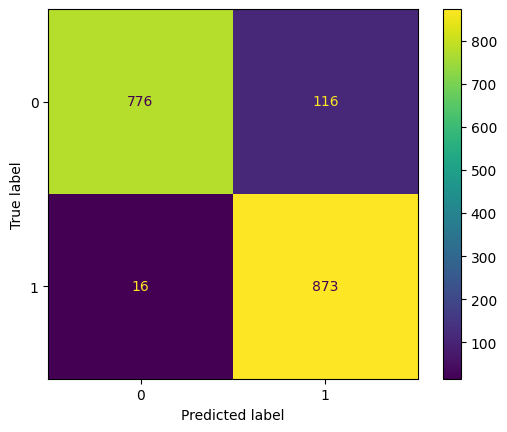

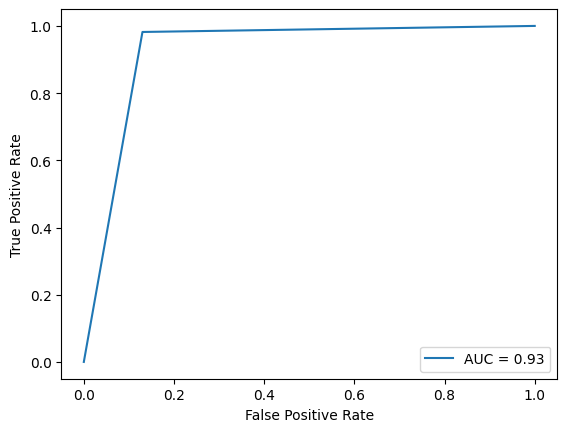

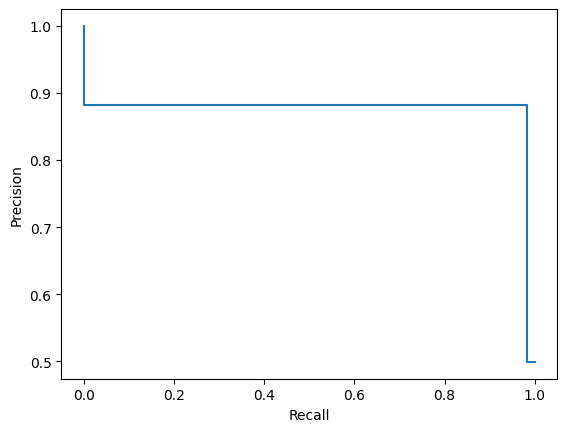

In [78]:
# classifcation report
print(forest_cr)

# confusion matrix display
forest_cm_display.plot()

# roc auc curve display
forest_roc_auc_display.plot()

# precision recall curve display
forest_prec_reca_display.plot()

### AdaBoost Classifier

In [79]:
from sklearn.ensemble import AdaBoostClassifier

In [80]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=500, algorithm="SAMME.R", learning_rate=0.1
)

ada_model = Pipeline([
    ('pca', pca),
    ('rf', rf_feature_select),
    ('ada', ada_clf)
])

ada_model.fit(X2d_train, y2d_train)

Pipeline(steps=[('pca', PCA(n_components=0.95)),
                ('rf',
                 SelectFromModel(estimator=RandomForestClassifier(max_leaf_nodes=9,
                                                                  n_jobs=-1))),
                ('ada',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                                    learning_rate=0.1, n_estimators=500))])

In [82]:
ada_predict = ada_model.predict(X2d_test)

Classifcation Report, Confusion Matrix, ROC AUC Curve, and Precision - Recall Curve for Ada Boost  Model

In [83]:
# classifcation report
ada_cr = metrics.classification_report(y2d_test, ada_predict)

# confusion matrix
ada_cm = metrics.confusion_matrix(y2d_test, ada_predict)
ada_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=ada_cm, display_labels= ada_model.classes_)

# roc auc curve 
ada_fpr, ada_tpr, ada_thresholds = metrics.roc_curve(y2d_test, ada_predict)
ada_roc_auc = metrics.auc(ada_fpr, ada_tpr)
ada_roc_auc_display = metrics.RocCurveDisplay(fpr=ada_fpr, tpr=ada_tpr, roc_auc=ada_roc_auc)

# precision recall curve
ada_precision, ada_recall, _ = metrics.precision_recall_curve(y2d_test, ada_predict)
ada_prec_reca_display = metrics.PrecisionRecallDisplay(precision=ada_precision, recall=ada_recall)


              precision    recall  f1-score   support

           0       0.98      0.93      0.95       892
           1       0.93      0.98      0.96       889

    accuracy                           0.95      1781
   macro avg       0.96      0.95      0.95      1781
weighted avg       0.96      0.95      0.95      1781



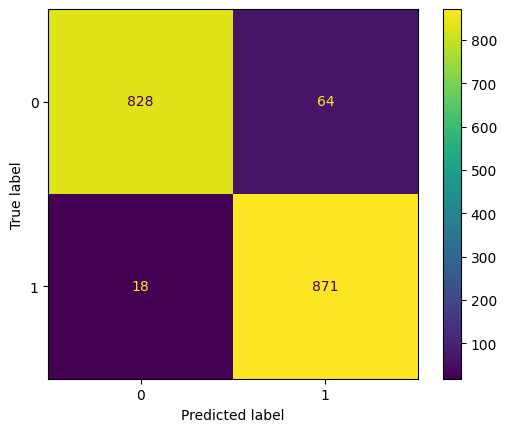

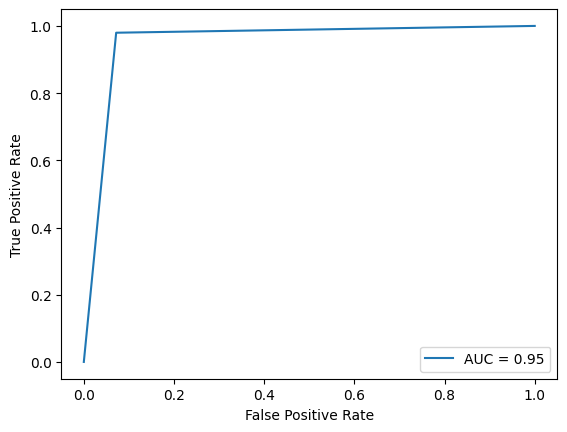

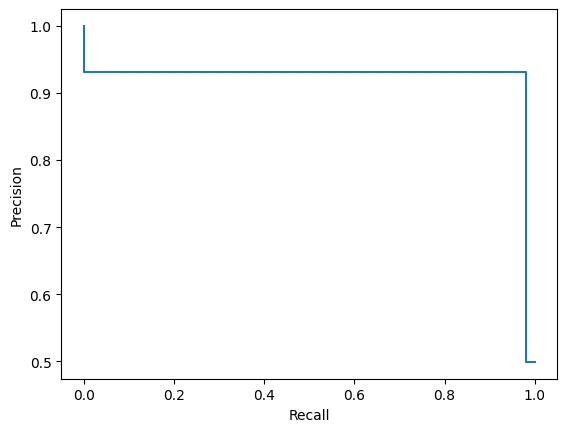

In [84]:
# classifcation report
print(ada_cr)

# confusion matrix display
ada_cm_display.plot()

# roc auc curve display
ada_roc_auc_display.plot()

# precision recall curve display
ada_prec_reca_display.plot()

### Gradient Boosting Classifer

In [85]:
from sklearn.ensemble import GradientBoostingClassifier

In [86]:
gdbst = GradientBoostingClassifier(
    max_depth=2, n_estimators=500, learning_rate=0.1
)

gdbst_model = Pipeline([
    ('pca', pca),
    ('rf', rf_feature_select),
    ('gd', gdbst)
])

gdbst_model.fit(X2d_train, y2d_train)

Pipeline(steps=[('pca', PCA(n_components=0.95)),
                ('rf',
                 SelectFromModel(estimator=RandomForestClassifier(max_leaf_nodes=9,
                                                                  n_jobs=-1))),
                ('gd',
                 GradientBoostingClassifier(max_depth=2, n_estimators=500))])

In [87]:
gdbst_predict = gdbst_model.predict(X2d_test)

Classifcation Report, Confusion Matrix, ROC AUC Curve, and Precision - Recall Curve for Gradient Boost  Model

In [88]:
# classifcation report
gdbst_cr = metrics.classification_report(y2d_test, gdbst_predict)

# confusion matrix
gdbst_cm = metrics.confusion_matrix(y2d_test, gdbst_predict)
gdbst_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=gdbst_cm, display_labels= gdbst_model.classes_)

# roc auc curve 
gdbst_fpr, gdbst_tpr, gdbst_thresholds = metrics.roc_curve(y2d_test, gdbst_predict)
gdbst_roc_auc = metrics.auc(gdbst_fpr, gdbst_tpr)
gdbst_roc_auc_display = metrics.RocCurveDisplay(fpr=gdbst_fpr, tpr=gdbst_tpr, roc_auc=gdbst_roc_auc)

# precision recall curve
gdbst_precision, gdbst_recall, _ = metrics.precision_recall_curve(y2d_test, gdbst_predict)
gdbst_prec_reca_display = metrics.PrecisionRecallDisplay(precision=gdbst_precision, recall=gdbst_recall)


              precision    recall  f1-score   support

           0       0.99      0.97      0.98       892
           1       0.97      0.99      0.98       889

    accuracy                           0.98      1781
   macro avg       0.98      0.98      0.98      1781
weighted avg       0.98      0.98      0.98      1781



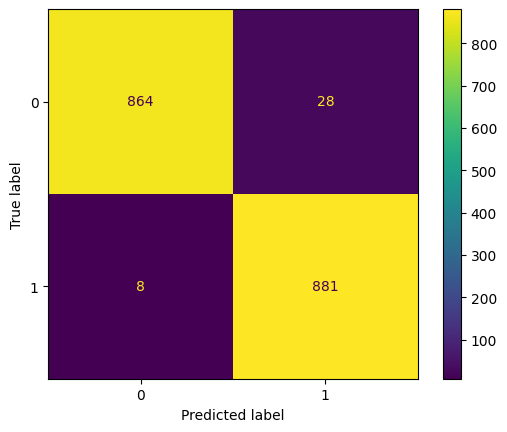

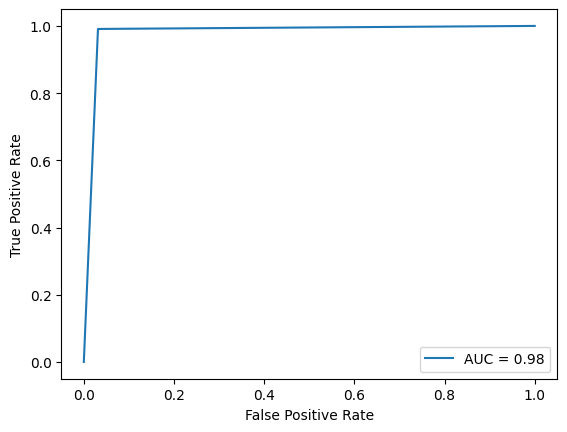

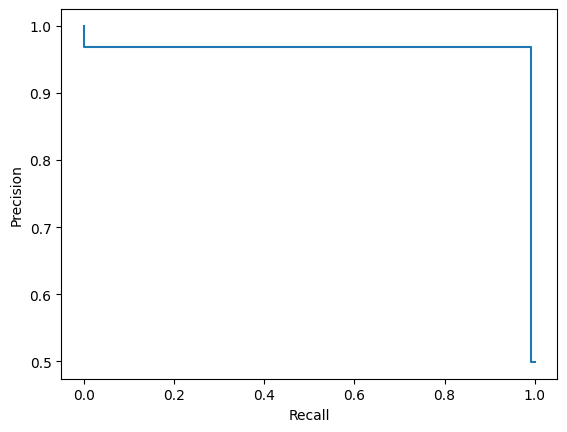

In [89]:
# classifcation report
print(gdbst_cr)

# confusion matrix display
gdbst_cm_display.plot()

# roc auc curve display
gdbst_roc_auc_display.plot()

# precision recall curve display
gdbst_prec_reca_display.plot()

## Artificial Neural Networks

### Perceptron

In [90]:
from sklearn.linear_model import Perceptron

In [91]:
per_model = Pipeline([
    ('pca', pca),
    ('rf', rf_feature_select),
    ('per', Perceptron(n_jobs=-1))
])

per_model.fit(X2d_train, y2d_train)

Pipeline(steps=[('pca', PCA(n_components=0.95)),
                ('rf',
                 SelectFromModel(estimator=RandomForestClassifier(max_leaf_nodes=9,
                                                                  n_jobs=-1))),
                ('per', Perceptron(n_jobs=-1))])

In [92]:
per_predict = per_model.predict(X2d_test)

Classifcation Report, Confusion Matrix, ROC AUC Curve, and Precision - Recall Curve for Perceptron Model

In [93]:
# classifcation report
per_cr = metrics.classification_report(y2d_test, per_predict)

# confusion matrix
per_cm = metrics.confusion_matrix(y2d_test, per_predict)
per_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=per_cm, display_labels= per_model.classes_)

# roc auc curve 
per_fpr, per_tpr, per_thresholds = metrics.roc_curve(y2d_test, per_predict)
per_roc_auc = metrics.auc(per_fpr, per_tpr)
per_roc_auc_display = metrics.RocCurveDisplay(fpr=per_fpr, tpr=per_tpr, roc_auc=per_roc_auc)

# precision recall curve
per_precision, per_recall, _ = metrics.precision_recall_curve(y2d_test, per_predict)
per_prec_reca_display = metrics.PrecisionRecallDisplay(precision=per_precision, recall=per_recall)


              precision    recall  f1-score   support

           0       0.89      0.90      0.90       892
           1       0.90      0.89      0.89       889

    accuracy                           0.90      1781
   macro avg       0.90      0.89      0.89      1781
weighted avg       0.90      0.90      0.89      1781



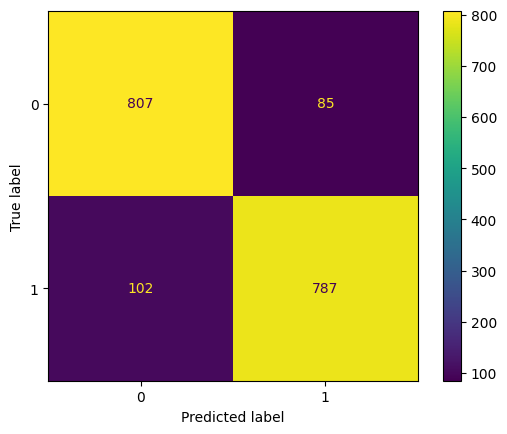

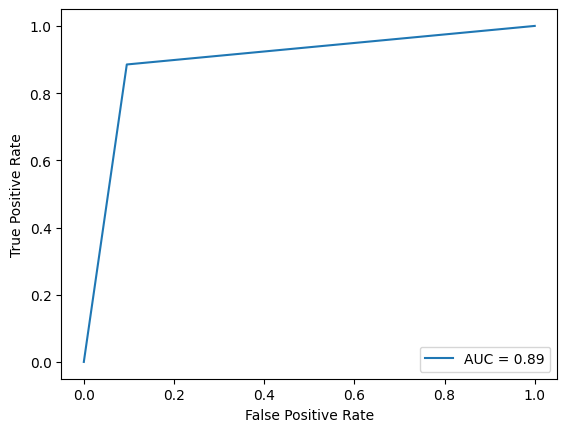

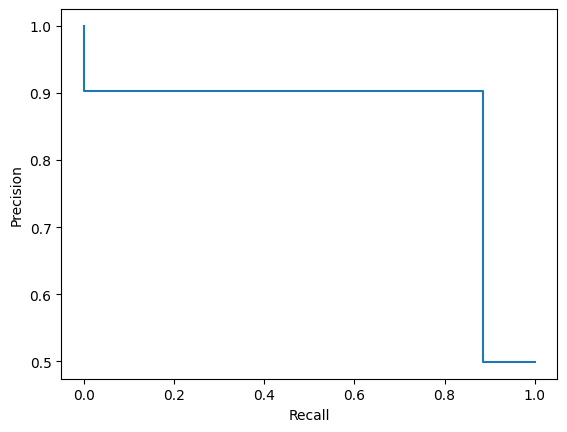

In [94]:
# classifcation report
print(per_cr)

# confusion matrix display
per_cm_display.plot()

# roc auc curve display
per_roc_auc_display.plot()

# precision recall curve display
per_prec_reca_display.plot()

### Multilayer Perceptron (MLP) Binary Classification

In [261]:
import tensorflow as tf
from tensorflow import keras

In [299]:
mlp_model = keras.models.Sequential()
mlp_model.add(keras.layers.Flatten(input_shape=[2, 20, 258]))
mlp_model.add(keras.layers.Dense(300, activation="relu"))
mlp_model.add(keras.layers.Dense(100, activation="relu"))
mlp_model.add(keras.layers.Dense(1, activation="sigmoid"))

In [300]:
mlp_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_15 (Flatten)        (None, 10320)             0         
                                                                 
 dense_51 (Dense)            (None, 300)               3096300   
                                                                 
 dense_52 (Dense)            (None, 100)               30100     
                                                                 
 dense_53 (Dense)            (None, 1)                 101       
                                                                 
Total params: 3,126,501
Trainable params: 3,126,501
Non-trainable params: 0
_________________________________________________________________


In [301]:
mlp_model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), 
    metrics=["accuracy"]
)

In [306]:
mlp_history = mlp_model.fit(
    X_train, y_train, epochs=10,
    validation_split=0.1
)

Epoch 1/10
284/284 [==============================] - 6s 17ms/step - loss: 0.1757 - accuracy: 0.9251 - val_loss: 0.0853 - val_accuracy: 0.9653
Epoch 2/10
284/284 [==============================] - 4s 16ms/step - loss: 0.0761 - accuracy: 0.9697 - val_loss: 0.0614 - val_accuracy: 0.9713
Epoch 3/10
284/284 [==============================] - 4s 16ms/step - loss: 0.0306 - accuracy: 0.9891 - val_loss: 0.0654 - val_accuracy: 0.9812
Epoch 4/10
284/284 [==============================] - 5s 16ms/step - loss: 0.0088 - accuracy: 0.9975 - val_loss: 0.0734 - val_accuracy: 0.9822
Epoch 5/10
284/284 [==============================] - 5s 17ms/step - loss: 0.0031 - accuracy: 0.9992 - val_loss: 0.0615 - val_accuracy: 0.9782
Epoch 6/10
284/284 [==============================] - 4s 16ms/step - loss: 0.0015 - accuracy: 0.9998 - val_loss: 0.0715 - val_accuracy: 0.9832
Epoch 7/10
284/284 [==============================] - 5s 16ms/step - loss: 4.4364e-04 - accuracy: 1.0000 - val_loss: 0.0791 - val_accuracy: 0.

Multilayer Preceptron (MLP) Multiclass Classification

In [314]:
mlp_model = keras.models.Sequential()
mlp_model.add(keras.layers.Flatten(input_shape=[2, 64, 258]))
mlp_model.add(keras.layers.Dense(300, activation="relu"))
mlp_model.add(keras.layers.Dense(100, activation="relu"))
mlp_model.add(keras.layers.Dense(9, activation="softmax"))

In [315]:
mlp_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_18 (Flatten)        (None, 33024)             0         
                                                                 
 dense_60 (Dense)            (None, 300)               9907500   
                                                                 
 dense_61 (Dense)            (None, 100)               30100     
                                                                 
 dense_62 (Dense)            (None, 9)                 909       
                                                                 
Total params: 9,938,509
Trainable params: 9,938,509
Non-trainable params: 0
_________________________________________________________________


In [316]:
mlp_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), 
    metrics=["accuracy"]
)

In [317]:
mlp_history = mlp_model.fit(
    X_hd_train, y_hd_train, epochs=10,
    validation_split=0.1
)

Epoch 1/10
160/160 [==============================] - 8s 47ms/step - loss: 0.9367 - accuracy: 0.6478 - val_loss: 0.3605 - val_accuracy: 0.9155
Epoch 2/10
160/160 [==============================] - 7s 46ms/step - loss: 0.1983 - accuracy: 0.9254 - val_loss: 0.1576 - val_accuracy: 0.9296
Epoch 3/10
160/160 [==============================] - 7s 44ms/step - loss: 0.0833 - accuracy: 0.9712 - val_loss: 0.1336 - val_accuracy: 0.9507
Epoch 4/10
160/160 [==============================] - 7s 45ms/step - loss: 0.0423 - accuracy: 0.9877 - val_loss: 0.1610 - val_accuracy: 0.9419
Epoch 5/10
160/160 [==============================] - 7s 46ms/step - loss: 0.0042 - accuracy: 0.9990 - val_loss: 0.0908 - val_accuracy: 0.9665
Epoch 6/10
160/160 [==============================] - 7s 46ms/step - loss: 0.0022 - accuracy: 0.9994 - val_loss: 0.0473 - val_accuracy: 0.9824
Epoch 7/10
160/160 [==============================] - 7s 45ms/step - loss: 3.3183e-04 - accuracy: 1.0000 - val_loss: 0.0479 - val_accuracy: 0.